<a href="https://colab.research.google.com/github/tomektom10/dataScienceBootCamp/blob/main/model_lstm_energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
df = pd.read_excel("PROGNOZY + dane_na_model.xlsx")

In [3]:
df

,Datetime,Unnamed: 1,SK Backcast,SK Residual Load Backcast,SK Residual Production Backcast,SK Exchange Day-Ahead Schedule Net Export MWh/h H Backcast,SK Consumption MWh/h 15min Backcast,SK Nuclear Production MWh/h 15min Backcast,SK Solar Photovoltaic Production MWh/h 15min Backcast,HU>SK Exchange Day-Ahead Schedule MWh/h H Backcast,PL>SK Exchange Day-Ahead Schedule MWh/h H Backcast,SK>HU Exchange Day-Ahead Schedule MWh/h H Backcast,SK>PL Exchange Day-Ahead Schedule MWh/h H Backcast,CZ>SK Exchange Day-Ahead Schedule MWh/h H Backcast,SK>CZ Exchange Day-Ahead Schedule MWh/h H Backcast,Bilans,Weighted average price of all trades (EUR/MWh),Minimal price (EUR/MWh),Maximal price (EUR/MWh),Price SK (EUR/MWh)
0,2023-01-01 00:00:00,1,1.47,2259.6,323.9,-1.3,2259.6,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1301.5,-1301.5,-5.00000,18.93,7.00,30.26,20.26
1,2023-01-01 01:00:00,2,-1.24,2221.9,346.4,58.5,2221.9,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1241.7,-1241.7,-4.99750,1.35,0.30,10.33,0.33
2,2023-01-01 02:00:00,3,-1.69,2164.5,129.3,-98.9,2164.5,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1399.2,-1399.2,-5.00000,2.05,0.50,10.50,0.50
3,2023-01-01 03:00:00,4,-3.52,2086.6,175.5,24.1,2086.6,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1276.2,-1276.2,-5.00000,2.26,0.00,10.50,0.50
4,2023-01-01 04:00:00,5,-3.14,2074.1,211.7,71.7,2074.1,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1228.6,-1228.6,-5.00000,3.12,0.00,10.10,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13865,2024-07-31 19:00:00,20,126.10,2884.8,1375.8,391.1,2903.9,1940.0,19.1,0.0,-1500.0,0.0,1500.0,1308.9,-1308.9,307.98750,170.96,124.01,194.00,94.80
13866,2024-07-31 20:00:00,21,161.32,2937.5,1361.0,330.8,2938.2,1940.0,0.8,0.0,-1500.0,0.0,1500.0,1369.2,-1369.2,133.26250,158.80,150.00,167.79,173.31
13867,2024-07-31 21:00:00,22,116.30,2860.2,1448.5,506.9,2860.2,1940.0,0.0,0.0,-1500.0,0.0,1500.0,1193.1,-1193.1,251.44005,177.99,130.51,202.93,97.29
13868,2024-07-31 22:00:00,23,102.43,2687.7,1323.4,534.4,2687.7,1940.0,0.0,0.0,-1500.0,0.0,1500.0,1165.6,-1165.6,400.00875,139.59,80.01,169.31,106.68


In [4]:
futures=['SK Residual Load Backcast', "SK Residual Production Backcast", 'Weighted average price of all trades (EUR/MWh)' ]

In [5]:
df.columns

Index(['Datetime', 'Unnamed: 1', 'SK Backcast', 'SK Residual Load Backcast',
       'SK Residual Production Backcast',
       'SK Exchange Day-Ahead Schedule Net Export MWh/h H Backcast',
       'SK Consumption MWh/h 15min Backcast',
       'SK Nuclear Production MWh/h 15min Backcast',
       'SK Solar Photovoltaic Production MWh/h 15min Backcast',
       'HU>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'PL>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>HU Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>PL Exchange Day-Ahead Schedule MWh/h H Backcast',
       'CZ>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>CZ Exchange Day-Ahead Schedule MWh/h H Backcast', 'Bilans',
       'Weighted average price of all trades (EUR/MWh)',
       'Minimal price (EUR/MWh)', 'Maximal price (EUR/MWh)',
       'Price SK (EUR/MWh)'],
      dtype='object')

In [6]:
target = df['Weighted average price of all trades (EUR/MWh)'].values

In [7]:
input = df[[ 'SK Residual Production Backcast', "SK Residual Load Backcast", "Weighted average price of all trades (EUR/MWh)"]].values

In [8]:
scaler = MinMaxScaler()

futures_scaled = scaler.fit_transform(input)




In [9]:
# Create sequences for LSTM
def create_sequences(data, window_size, prediction_size):
    X = []
    y = []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + prediction_size, -1])  # Predicting only the price
    return np.array(X), np.array(y)

In [10]:
#liczbs godzina na bazie ktorych generujemy predykcje
window_size = 48

prediction_size = 24

In [11]:
X,y = create_sequences (futures_scaled, window_size, prediction_size)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of X_train: (11039, 48, 3)
Shape of y_train: (11039, 24)


In [14]:
# # Przekształcenie danych do formatu akceptowalnego przez LSTM (próbki, kroki czasowe, cechy)
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# # X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
# Inicjalizacja modelu LSTM
model = Sequential()

# Dodanie warstwy LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Dodanie kolejnej warstwy LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dodanie warstwy wyjściowej
model.add(Dense(units = prediction_size))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Wyświetlenie architektury modelu
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 48, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,224 (125.88 KB)

 Trainable params: 32,224 (125.88 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Trenowanie modelu LSTM
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.0250 - val_loss: 0.0018
Epoch 2/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - loss: 0.0029 - val_loss: 0.0018


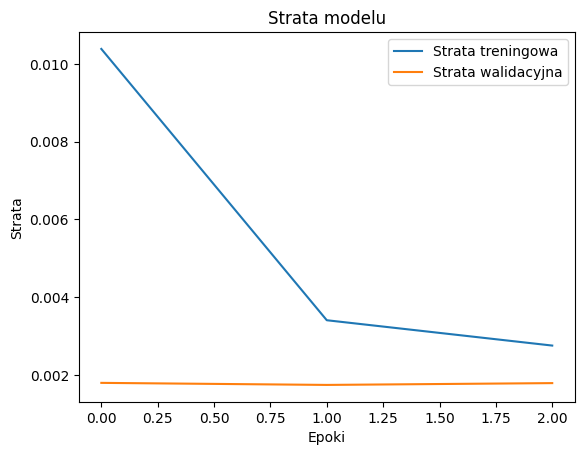

In [19]:
# Wykres strat treningowych i walidacyjnych
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [20]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018
Test Loss: 0.0017876700730994344


In [21]:
# Make predictions
predictions = model.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [37]:
y_test_24 = y_test[:, -1]

In [38]:
predictions_24 = predictions[:, -1]

In [40]:
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_test_24.shape[0], 2)), y_test_24.reshape(-1, 1)], axis=1))[:, -1]


In [34]:
np.concatenate([np.zeros((y_test.shape[0], 2)), y_test],axis=1).shape

(2760, 26)

In [36]:
np.zeros((y_test.shape[0], 2)).shape

(2760, 2)

In [41]:
predictions_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((predictions_24.shape[0], 2)), predictions_24.reshape(-1, 1)], axis=1))[:, -1]

In [23]:
# y_test_rescaled = scaler.inverse_transform(y_test)



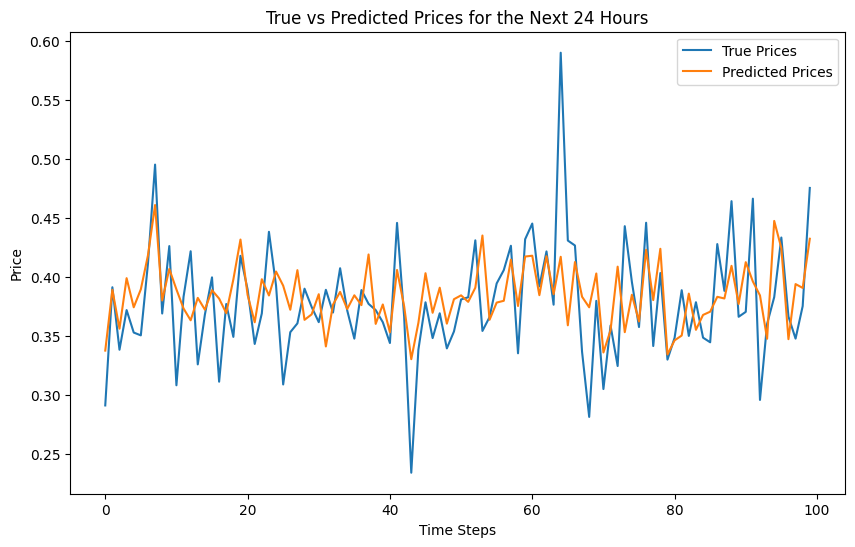

In [42]:
# Plot true vs predicted prices for the next 24 hours
plt.figure(figsize=(10, 6))
plt.plot(y_test_24[:100], label='True Prices')
plt.plot(predictions_24[:100], label='Predicted Prices')
plt.title('True vs Predicted Prices for the Next 24 Hours')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
true_24th = y_test[:, -1]        # True values for the 24th hour
predicted_24th = predictions[:, -1]  # Predicted values for the 24th hour

In [44]:
percent_errors = np.abs(true_24th - predicted_24th) / np.abs(true_24th) * 100

In [45]:
sr_blad = np.mean(percent_errors)

In [46]:
sr_blad

8.42473225014884

In [29]:
##### do zmiany parametrow sieciu moge zmienic size okna, liczbe unit do danych,

In [47]:
percent_errors = np.abs(y_test_24 - predictions_24) / np.abs(y_test_24) * 100

In [48]:
sr_blad_real = np.mean(percent_errors)

In [49]:
sr_blad_real

8.42473225014884

In [ ]:
###### WPROWADZANIE REALNYCH WARTOSCI

In [50]:
X_test[-1]

array([[0.64344977, 0.48443925, 0.38388988],
       [0.61660858, 0.47487339, 0.3937136 ],
       [0.56834369, 0.42648141, 0.37071315],
       [0.52000303, 0.42184998, 0.36143846],
       [0.53987347, 0.44171753, 0.33615365],
       [0.53345204, 0.4387309 , 0.33647719],
       [0.53915366, 0.42752024, 0.32920253],
       [0.54748826, 0.43440246, 0.33062413],
       [0.60251553, 0.44812362, 0.34537932],
       [0.6691923 , 0.47253603, 0.36133061],
       [0.68175102, 0.49552006, 0.38124277],
       [0.70936884, 0.53027745, 0.3987235 ],
       [0.71880209, 0.52716097, 0.41577286],
       [0.72259054, 0.49274986, 0.40814526],
       [0.68212987, 0.42544258, 0.3918018 ],
       [0.65600849, 0.36203091, 0.38938018],
       [0.68228141, 0.31082543, 0.3694092 ],
       [0.67144643, 0.2625633 , 0.37237985],
       [0.6499659 , 0.24161364, 0.37034059],
       [0.66849144, 0.24607194, 0.37101708],
       [0.6693249 , 0.26632905, 0.36894841],
       [0.7111873 , 0.30879107, 0.37819369],
       [0.

In [54]:
predictions = model.predict(np.array([X_test[-1]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [57]:
predictions.shape

(1, 24)

In [63]:
predictions_24 = np.array([predictions[:, -1]])

In [64]:
predictions_24.shape

(1, 1)

In [65]:
predictions_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((predictions_24.shape[0], 2)), predictions_24.reshape(-1, 1)], axis=1))[:, -1]

In [66]:
predictions_rescaled

array([101.17884162])

In [ ]:
#wczytywanie realnych danych

In [77]:
df1 = pd.read_excel("nowe_dane1.xlsx")

In [78]:
df1.values

array([[2316.46,  689.63,   87.78],
       [2228.42,  668.88,   96.45],
       [2154.2 ,  571.75,   91.05],
       [2101.5 ,  589.57,   91.38],
       [2140.44,  631.83,   96.37],
       [2275.89, 1038.93,   97.12],
       [2612.5 ,  989.35,  200.2 ],
       [2795.79, 1044.65,  217.87],
       [2834.83, 1155.05,  173.51],
       [2791.76, 1225.4 ,  114.97],
       [2696.27,  784.23,   95.51],
       [2743.58,  538.25,   89.89],
       [2817.08,  248.82,   88.74],
       [2876.81,  109.23,   90.11],
       [2922.82,   20.18,   98.99],
       [2981.09,  394.3 ,  115.54],
       [3099.98,  710.43,  189.96],
       [3156.7 ,  794.65,  249.32],
       [3157.92, -242.72,  436.78],
       [3209.65, -781.1 ,  515.42],
       [3196.17, -194.9 ,  347.97],
       [3003.81, 1126.95,  180.84],
       [2791.42,  978.48,   97.11],
       [2611.6 ,  954.18,   99.64],
       [2464.5 , 1011.85,   96.47],
       [2362.01,  993.28,  103.54],
       [2297.95,  921.98,  101.54],
       [2289.69, 1016.22,   

In [79]:
probka = df1.values

In [80]:
probka_scaled = scaler.transform(probka)

In [81]:
probka_scaled.shape

(48, 3)

In [83]:
predictions = model.predict(np.array([probka_scaled]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [84]:
predictions.shape

(1, 24)

In [85]:
predictions = predictions.reshape(24)

In [86]:
predictions_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], 2)), predictions.reshape(-1, 1)], axis=1))[:, -1]

In [87]:
predictions_rescaled

array([178.48034743, 190.78566983, 169.4277691 , 177.11518345,
       144.89381788, 195.65864559, 176.41953042, 195.1016672 ,
       198.87469956, 225.92835257, 203.48920306, 205.06429405,
       196.31599743, 204.0331712 , 178.39444332, 220.68084585,
       197.37350555, 174.62493711, 192.61798678, 196.30867157,
       184.44770381, 181.05157344, 166.07130783, 157.63498355])